In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
torch.manual_seed(1)

In [2]:
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [3]:
text = open("data/alice.txt", 'r').read()

In [4]:
words = tokenize(text)

In [5]:
len(words)

26683

In [6]:
vocab = set(words)
word_to_idx = {word:i for i, word in enumerate(vocab)}

In [7]:
len(vocab)

2854

In [8]:
class SkipGramWithSoftmax(nn.Module):
    def __init__(self, vocab_size, n_embedding):
        super(SkipGramWithSoftmax, self).__init__()
        self.embedding_center = nn.Embedding(vocab_size, n_embedding)
        self.embedding_context = nn.Embedding(vocab_size, n_embedding)
        nn.init.uniform_(self.embedding_center.weight, -1, 1)
        nn.init.uniform_(self.embedding_context.weight, -1, 1)
    def forward(self, center_word):
        emb_center = self.embedding_center(center_word)
        out = torch.matmul(emb_center, self.embedding_context.weight.T) # logits for every word in the corpus
        return out

In [9]:
def generate_data(words, vocab, context_size):
    x, y = [], []
    for i, word in enumerate(words):
        l = max(0, i - context_size)
        r = min(len(words) - 1, i + context_size)
        for j in range(l, r + 1):
            if i != j:
                x.append(word_to_idx[word])
                y.append(word_to_idx[words[j]])
    return x, y

In [10]:
X, Y = generate_data(words, vocab, context_size=2)

In [11]:
len(X), len(Y)

(106726, 106726)

In [12]:
vocab_size = len(vocab)
n_embedding = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkipGramWithSoftmax(vocab_size, n_embedding).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=2) # corpus too small so learning quite slow
criterion = nn.CrossEntropyLoss()
batch_size = 128

In [13]:
class SkipGramDataset(Dataset):
    def __init__(self, center_words, context_words):
        self.center_words = center_words
        self.context_words = context_words
    def __len__(self):
        return len(self.center_words)
    def __getitem__(self, index):
        return self.center_words[index], self.context_words[index]

In [14]:
dataset = SkipGramDataset(X, Y)

In [15]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
losses = []
for epoch in range(50):
    model.train()
    total_loss = 0

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        total_loss += loss.item()
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {total_loss / len(dataloader)}")

Epoch: 0, Loss: 8.018909490365775
Epoch: 1, Loss: 6.675744722787139
Epoch: 2, Loss: 6.28331220235756
Epoch: 3, Loss: 6.068515945109818
Epoch: 4, Loss: 5.924978163602541
Epoch: 5, Loss: 5.817607342768058
Epoch: 6, Loss: 5.733316663929599
Epoch: 7, Loss: 5.6622818568341735
Epoch: 8, Loss: 5.600849528392728
Epoch: 9, Loss: 5.547561430530869
Epoch: 10, Loss: 5.497011930250721
Epoch: 11, Loss: 5.453989441732137
Epoch: 12, Loss: 5.41194068785194
Epoch: 13, Loss: 5.374003807131907
Epoch: 14, Loss: 5.33821716468683
Epoch: 15, Loss: 5.304316513258205
Epoch: 16, Loss: 5.272752379341949
Epoch: 17, Loss: 5.243302674030514
Epoch: 18, Loss: 5.21503019275711
Epoch: 19, Loss: 5.188311577415009
Epoch: 20, Loss: 5.164033483830002
Epoch: 21, Loss: 5.139807190540597
Epoch: 22, Loss: 5.117488816487703
Epoch: 23, Loss: 5.097157120990524
Epoch: 24, Loss: 5.076041720182204
Epoch: 25, Loss: 5.056978848912447
Epoch: 26, Loss: 5.039445341348077
Epoch: 27, Loss: 5.022212553939087
Epoch: 28, Loss: 5.00599870407324

Text(0.5, 0, 'Iterations')

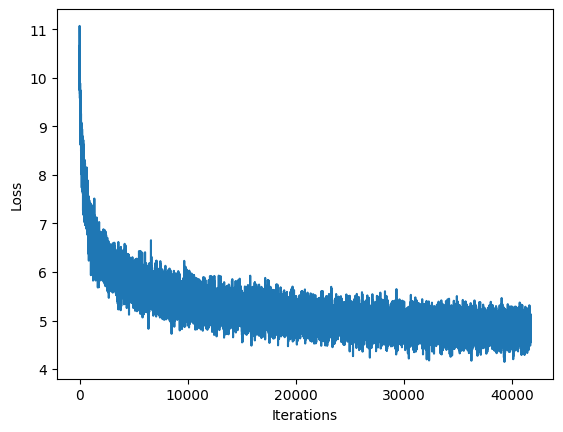

In [ ]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Iteration")

In [36]:
  class SkipGramWithNegativeSampling(nn.Module):
    def __init__(self, vocab_size, n_embedding, n_neg_samples):
      super(SkipGramWithNegativeSampling, self).__init__()
      self.embedding_center = nn.Embedding(vocab_size, n_embedding)
      self.embedding_context = nn.Embedding(vocab_size, n_embedding)
      self.n_neg_samples = n_neg_samples
      nn.init.uniform_(self.embedding_center.weight, -1, 1)
      nn.init.uniform_(self.embedding_context.weight, -1, 1)

    def forward(self, center_word, context_word, neg_samples):
      emb_center = self.embedding_center(center_word) # batch_size * n_embedding
      emb_context = self.embedding_context(context_word) # batch_size * n_embedding
      pos_score = torch.sum(emb_center * emb_context, dim=1)
      pos_loss = F.logsigmoid(pos_score)
      neg_emb = self.embedding_context(neg_samples) # batch_size * n_neg_samples * n_embedding
      neg_score = torch.bmm(neg_emb, emb_center.unsqueeze(2)).squeeze(2) # batch_size * n_neg_samples
      neg_loss = F.logsigmoid(-neg_score).sum(dim=1) # sum the score over all negative samples in each batch
      loss = -(pos_loss + neg_loss).mean()
      return loss


In [47]:
vocab_size = len(vocab)
n_embedding = 50
n_neg_samples = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkipGramWithNegativeSampling(vocab_size, n_embedding, n_neg_samples).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
batch_size = 64
losses = []

In [48]:
for epoch in range(100):
    model.train()
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        neg_samples = torch.randint(0, vocab_size, (x_batch.shape[0], n_neg_samples), dtype=torch.long, device=device)
        optimizer.zero_grad()
        loss = model(x_batch, y_batch, neg_samples)
        total_loss += loss.item()
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch + 1}, Loss: {total_loss / len(dataloader)}")

Epoch: 1, Loss: 10.333627321165528
Epoch: 2, Loss: 7.126172692941533
Epoch: 3, Loss: 4.881166250585652
Epoch: 4, Loss: 4.006150830849755
Epoch: 5, Loss: 3.494672263554818
Epoch: 6, Loss: 3.163889623946137
Epoch: 7, Loss: 2.923466889120692
Epoch: 8, Loss: 2.7423852682113647
Epoch: 9, Loss: 2.6008412166179227
Epoch: 10, Loss: 2.4869763389479913
Epoch: 11, Loss: 2.397011666132106
Epoch: 12, Loss: 2.3230522360733086
Epoch: 13, Loss: 2.2548316344082786
Epoch: 14, Loss: 2.2013452897826546
Epoch: 15, Loss: 2.154049292313967
Epoch: 16, Loss: 2.1141228164128547
Epoch: 17, Loss: 2.0773806318962316
Epoch: 18, Loss: 2.0451128276989614
Epoch: 19, Loss: 2.018998809855619
Epoch: 20, Loss: 1.9884350375591708
Epoch: 21, Loss: 1.969173247579762
Epoch: 22, Loss: 1.946540519916754
Epoch: 23, Loss: 1.9260098248076953
Epoch: 24, Loss: 1.909281200928082
Epoch: 25, Loss: 1.8930709999528148
Epoch: 26, Loss: 1.8733696077081512
Epoch: 27, Loss: 1.8608919923825802
Epoch: 28, Loss: 1.845914678179103
Epoch: 29, Los

Text(0, 0.5, 'Loss')

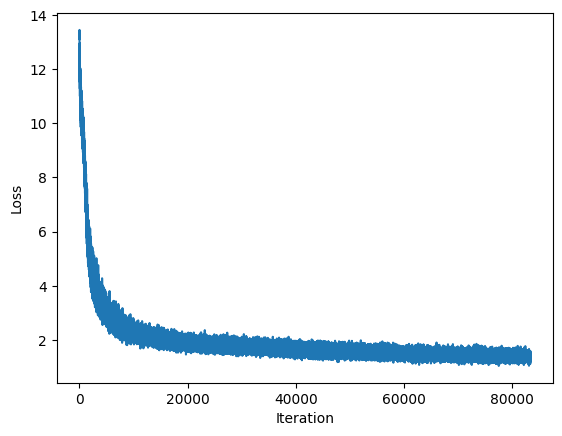

In [49]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [62]:
word_embeddings = model.embedding_center.weight.data

In [63]:
word_embeddings[:5]

tensor([[ 0.2456, -0.1807,  0.1295, -0.7248,  0.4956, -0.9817, -0.0931,  0.2542,
         -0.4017,  0.2621, -0.9874, -1.2889,  0.6764,  0.1786, -0.6319,  0.4088,
         -0.3498,  0.1790,  0.2639, -0.5425, -0.5473, -0.2556,  0.2829, -0.7100,
          0.3411,  0.4205, -0.3762, -0.7417, -0.3734, -0.6963, -0.8190,  1.2973,
          0.3197,  0.9738, -1.2400,  0.0756, -0.9272,  0.9797,  0.5273,  0.4195,
         -0.9977,  0.3588,  0.2829,  0.9091, -0.8444, -0.2680, -0.1498,  0.7980,
         -0.4735, -0.3149],
        [-0.5859,  0.2038,  0.2336, -0.6723, -0.2174, -1.1650, -0.0422, -1.0829,
          0.1326, -0.1189, -0.5058,  0.3505,  0.6213,  0.8470, -1.1276, -0.1760,
          0.0429, -0.4506, -0.1466, -0.3198, -0.5343,  0.0021, -0.1302, -0.8501,
          0.9619,  0.6735,  0.2173, -0.8132,  0.3177, -0.4865, -0.0257,  0.0441,
         -0.9730, -0.2847, -0.7365,  0.0883, -0.0443,  0.9694,  0.7920,  0.4190,
          0.1936, -0.6834, -0.7139, -0.3096, -0.0720, -0.7734,  0.5538,  0.5670,


In [92]:
def get_word_embedding(word):
  try:
    idx = word_to_idx[word]
    return word_embeddings[idx]
  except Exception as e:
    print("word is not present in the vocabulary")

def cosine_similarity(vec1, vec2):
  return F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()

def most_similar_words(word, top_n=10):
  try:
    word_embedding = get_word_embedding(word)
    similarities = []
    for other_word, index in word_to_idx.items():
      if other_word != word:
        other_embedding = get_word_embedding(other_word)
        sim = cosine_similarity(word_embedding, other_embedding)
        similarities.append((other_word, sim))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]
  except Exception as e:
    print(e)